In [49]:
import numpy as np
from keras import applications, callbacks
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers

import keras.backend as K

In [50]:
x_train=np.load('dataset/x_train_np.npy')
x_cv=np.load('dataset/x_cv_np.npy')
y_train=np.load('dataset/y_train_np.npy')
y_cv=np.load('dataset/y_cv_np.npy')

In [51]:
x_test=np.load('dataset/x_test_np.npy', allow_pickle=True)
y_test=np.load('dataset/y_test_np.npy')

VGG16 Bottleneck

In [52]:
model = applications.VGG16(weights='imagenet', include_top=False)


x_train_bottleneck = model.predict(x_train)
x_cv_bottleneck = model.predict(x_cv)

np.save('dataset/x_train_bottleneck.npy', x_train_bottleneck)
np.save('dataset/x_cv_bottleneck.npy', x_cv_bottleneck)

print(x_train_bottleneck[0].shape)

(2, 2, 512)


In [53]:
x_train_bottleneck[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [54]:
x_train_bottleneck = np.load('dataset/x_train_bottleneck.npy')
x_cv_bottleneck = np.load('dataset/x_cv_bottleneck.npy')

In [55]:
x_train_bottleneck.shape[1:]

(2, 2, 512)

Top Model

In [56]:
top_model=Sequential()
top_model.add(Flatten(input_shape=x_train_bottleneck.shape[1:]))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [57]:
top_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 131,201
Trainable params: 131,201
Non-trainable params: 0
_________________________________________________________________


In [58]:
class Custom_lr(callbacks.Callback):

    def on_train_begin(self, logs={}):
	    K.set_value(self.model.optimizer.lr, 0.001)
 
    def on_epoch_begin(self, epoch, logs={}):
        lr_present=K.get_value(self.model.optimizer.lr)
        #print(epoch)
        if (epoch%10==0) and epoch:
        	
            K.set_value(self.model.optimizer.lr, lr_present/((epoch)**0.5))
            print(K.get_value(self.model.optimizer.lr))
            print(lr_present/((epoch)**0.5))

callbacks = [
    Custom_lr()
    ]

In [59]:
top_model.fit(x_train_bottleneck, y_train,
          epochs=35,
          batch_size=32,
          validation_data=(x_cv_bottleneck, y_cv), callbacks=callbacks,)

Epoch 1/35
213/213 [==============================] - 1s 2ms/step - loss: 1.2477 - accuracy: 0.5741 - val_loss: 0.6316 - val_accuracy: 0.6611
Epoch 2/35
213/213 [==============================] - 0s 2ms/step - loss: 0.6237 - accuracy: 0.6501 - val_loss: 0.6092 - val_accuracy: 0.6786
Epoch 3/35
213/213 [==============================] - 0s 2ms/step - loss: 0.5723 - accuracy: 0.6904 - val_loss: 0.5951 - val_accuracy: 0.6906
Epoch 4/35
213/213 [==============================] - 0s 2ms/step - loss: 0.5441 - accuracy: 0.7132 - val_loss: 0.5736 - val_accuracy: 0.7043
Epoch 5/35
213/213 [==============================] - 0s 2ms/step - loss: 0.5185 - accuracy: 0.7266 - val_loss: 0.5992 - val_accuracy: 0.6971
Epoch 6/35
213/213 [==============================] - 0s 2ms/step - loss: 0.4974 - accuracy: 0.7343 - val_loss: 0.5830 - val_accuracy: 0.7173
Epoch 7/35
213/213 [==============================] - 0s 2ms/step - loss: 0.4710 - accuracy: 0.7449 - val_loss: 0.5942 - val_accuracy: 0.7221
Epoch 

In [60]:
top_model.save('top_model_full_data_custom_lr_weights.h5') # best

Fine Tune Model

In [69]:
x_train = np.load('dataset/x_train_np.npy')
x_cv = np.load('dataset/x_cv_np.npy')

y_train=np.load('dataset/y_train_np.npy')
y_cv=np.load('dataset/y_cv_np.npy')

In [70]:
# load VGG16
vgg_model=applications.VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

In [71]:
model_aug=Sequential()
model_aug.add(vgg_model)

In [72]:
top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 512)))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights('top_model_full_data_custom_lr_weights.h5')

model_aug.add(top_model)

In [73]:
for layer in model_aug.layers[0].layers[:17]:
    layer.trainable=False

In [74]:
model_aug.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-6), metrics=['accuracy'])

In [75]:
model_aug.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
sequential_12 (Sequential)   (None, 1)                 131201    
Total params: 14,845,889
Trainable params: 2,491,009
Non-trainable params: 12,354,880
_________________________________________________________________


In [76]:
model_aug.fit(x_train, y_train, epochs=35, batch_size=32, validation_data=(x_cv, y_cv), verbose=1)

Epoch 1/35
213/213 [==============================] - 194s 910ms/step - loss: 0.1593 - accuracy: 0.9278 - val_loss: 0.8698 - val_accuracy: 0.7571
Epoch 2/35
213/213 [==============================] - 193s 904ms/step - loss: 0.1554 - accuracy: 0.9284 - val_loss: 0.8786 - val_accuracy: 0.7568
Epoch 3/35
213/213 [==============================] - 195s 915ms/step - loss: 0.1524 - accuracy: 0.9297 - val_loss: 0.8863 - val_accuracy: 0.7557
Epoch 4/35
213/213 [==============================] - 206s 965ms/step - loss: 0.1497 - accuracy: 0.9316 - val_loss: 0.8947 - val_accuracy: 0.7551
Epoch 5/35
213/213 [==============================] - 198s 930ms/step - loss: 0.1472 - accuracy: 0.9324 - val_loss: 0.9004 - val_accuracy: 0.7568
Epoch 6/35
213/213 [==============================] - 194s 909ms/step - loss: 0.1450 - accuracy: 0.9341 - val_loss: 0.9092 - val_accuracy: 0.7581
Epoch 7/35
213/213 [==============================] - 187s 877ms/step - loss: 0.1428 - accuracy: 0.9341 - val_loss: 0.9132 -

In [77]:
model_aug.save('fine_tuned_model_adam_weights_new.h5')

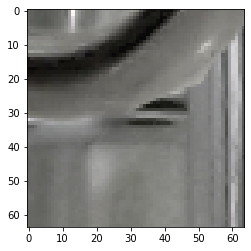

In [108]:
import matplotlib.pyplot as plt

plt.imshow(x_train[1])

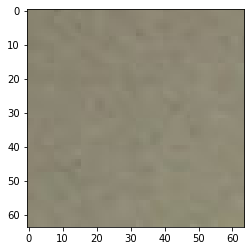

In [109]:
plt.imshow(x_test[1][0])

In [169]:
result = model_aug.predict(x_test[13])

In [165]:
y_test[12]

0

In [153]:
result.reshape(50, 67)

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 1]])

In [168]:
np.count_nonzero(result)/len(result) < 0.5

False

In [134]:
len(result)

192

In [102]:
x_train[1].shape

(64, 64, 3)

In [ ]:
x_test[1]

In [113]:
result = model_aug.predict_classes(x_test[2])

array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])